In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
from copy import deepcopy
from collections import defaultdict

sns.set()

# Columns with categorical data that needs to be encoded
categorical_cols = ['serve','hitpoint','outside.sideline','outside.baseline','same.side','server.is.impact.player','outcome','gender','previous.hitpoint']

# Columns in the Data That Should Be Scaled
scaled_data = ['rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 
               'player.distance.travelled', 'player.impact.depth', 
               'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 
               'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net', 
               'player.impact.distance.from.center']

# Columns to be dropped
train_dropcols = ['ID',  'gender', 'same.side', 'server.is.impact.player', 
                  'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
                  'outside.sideline', 'player.distance.from.center', 'depth', 
                  'player.distance.from.other.length',
                  'player.distance.from.other.width', 'previous.time.to.net',
                  'player.impact.distance.from.center', 'opponent.distance.from.center', 
                  'player.from.net.penultimate','net.clearance.difference']

# Columns to be dropped
test_dropcols = ['ID',  'gender', 'same.side', 'server.is.impact.player', 'depth',
                 'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
                 'outside.sideline', 'player.distance.from.center', 'previous.time.to.net',
                 'player.distance.from.other.length', 'player.impact.distance.from.center',
                 'player.distance.from.other.width', 'opponent.distance.from.center', 
                 'player.from.net.penultimate', 
                 'net.clearance.difference' ]



######################## Load Data #################
raw_mw_train = pd.read_csv('tennis_data/train-1542197608821.csv')
raw_mw_test = pd.read_csv("tennis_data/test-1542197608821.csv")
raw_mw_train.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,0.705435,12.5628,2.0724,True,F,0.445318,False,UE,mens,8644
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,3.856600,12.3544,5.1124,False,B,0.432434,False,FE,mens,1182
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,2.908892,13.8620,1.6564,False,F,0.397538,True,FE,mens,9042
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,0.557554,14.2596,0.1606,True,B,0.671984,True,UE,mens,1222
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,3.945317,11.3658,1.1082,False,F,0.340411,False,W,mens,4085


In [2]:
#  import pixiedust
# print(raw_mw_train.isnull().sum())

In [4]:
####################### Feature Engineering #################
def feature_engineer(data):
    
    # Speed difference between previous and last shot
    data['speed.difference'] = data['speed'] - data['previous.speed']
    
    # Net clearance difference between previous and last shot
    data['net.clearance.difference'] = data['net.clearance'] - data['previous.net.clearance']
    
    # The actual distance the player was from the sideline
    data['true.distance.from.sideline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['distance.from.sideline'], 
                                               data['outside.sideline'])]

    # The actual distance the player was from the baseline
    data['true.distance.from.baseline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['depth'], 
                                               data['outside.baseline'])]

    # Opponent distance to net + player distance to net
    data['player.distance.from.other.length'] = data['player.depth'] + data['opponent.depth']

    # Opponent distance from center + player distance to center
    data['player.distance.from.other.width'] = [math.fabs(p_center - o_center)
                                                     if boolean else p_center + o_center
                                                     for p_center, o_center, boolean in 
                                                     zip(data['player.distance.from.center'], 
                                                         data['opponent.distance.from.center'], 
                                                         data['same.side'])]
    
    # Distance penultimate shot was made from net- previous to net (s) * penultimate shot (m/s)
    data['player.from.net.penultimate'] = data['previous.speed'] * data['previous.time.to.net']
    
    return data
 
# Perform Feature Engineering
mw_train = feature_engineer(raw_mw_train)
mw_test = feature_engineer(raw_mw_test)

# mw_test.shape
# mw_train.shape
# mw_test.head()

In [5]:
mw_train.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,outcome,gender,ID,speed.difference,net.clearance.difference,true.distance.from.sideline,true.distance.from.baseline,player.distance.from.other.length,player.distance.from.other.width,player.from.net.penultimate
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,UE,mens,8644,3.201450,-1.372257,3.474766,6.797621,26.2332,1.8394,14.389823
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,FE,mens,1182,-0.678148,0.353704,2.540801,-2.608708,24.9902,7.4286,14.729042
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,FE,mens,9042,-17.489938,-0.631778,3.533166,9.435749,27.5616,3.7472,15.824638
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,UE,mens,1222,11.818491,-0.472339,-0.586885,3.342180,27.4088,0.1418,16.812251
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,W,mens,4085,-1.246771,-0.049569,0.918725,5.499119,25.4968,1.4232,12.524057


In [6]:
# %%pixie_debugger

def encode(train, test):
    
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)
    
    # Encode all the columns
    train[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
    test_ids = test['ID']

    # Making a deepcopy so we can encode the test data (test data does not have an outcome column)
    temp = deepcopy(categorical_cols)
    temp.remove('outcome')
    e = deepcopy(d)
    del e['outcome']  
    test[temp] = test[temp].apply(lambda x: e[x.name].transform(x))
    
    # Drop the unecessary features
    train = train.drop(train_dropcols, axis=1) 
    test = test.drop(test_dropcols  , axis=1)
    
    return train, test, test_ids

mw_train, mw_test, mw_test_ids  = encode(mw_train, mw_test)

In [7]:
# %%pixie_debugger
data_train_X = mw_train.loc[:, mw_train.columns != 'outcome']
data_train_y = mw_train['outcome']

In [8]:
data_train_y.head()

0    1
1    0
2    0
3    1
4    2
Name: outcome, dtype: int64

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

train_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, 
                               subsample= 0.9, colsample_bytree= 1.0, 
                               eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)

y_pred = cross_val_predict(train_xgb_model, data_train_X, data_train_y,cv=4)
confusion_matrix(data_train_y,y_pred)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

array([[1327,  417,   74],
       [ 299, 3071,  131],
       [  43,   61, 2578]], dtype=int64)

In [10]:
y_pred.shape

(8001,)

In [11]:
from sklearn.model_selection import cross_val_score

CV = 5

###### Model #######
train_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, 
                               subsample= 0.9, colsample_bytree= 1.0, max_depth= 5, 
                               eval_metric= 'mlogloss', min_child_weight= 1)
m_loss = cross_val_score(train_xgb_model, data_train_X, data_train_y, 
                         scoring='neg_log_loss', cv = CV, n_jobs=-1)

m_acc = cross_val_score(train_xgb_model, data_train_X, data_train_y, 
                        scoring='accuracy', cv = CV, n_jobs=-1)

print("Number of k-folds: " + str(CV))
print("---------------------------------")

print("Model Results")
print("Accuracy: {:.4%}".format(np.mean(m_acc)))
print("Log Loss: {}".format(np.mean(m_loss)))

Number of k-folds: 5
---------------------------------
Model Results
Accuracy: 87.2143%
Log Loss: -0.3246740177469095


E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 87.4453%
Log Loss: 0.31028714097790805
----------------
('speed', 0.023972603)
('net.clearance', 0.13943249)
('distance.from.sideline', 0.03033268)
('player.distance.travelled', 0.059686888)
('player.impact.depth', 0.0665362)
('player.depth', 0.04696673)
('previous.speed', 0.07387476)
('previous.net.clearance', 0.05479452)
('previous.distance.from.sideline', 0.07093933)
('previous.depth', 0.061643835)
('opponent.depth', 0.098825835)
('speed.difference', 0.07925636)
('true.distance.from.sideline', 0.06996086)
('true.distance.from.baseline', 0.123776905)


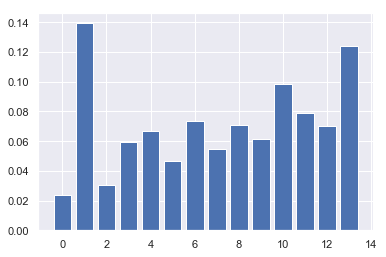

In [109]:
# Create new training and validation set using scikit's train_test_split
mw_train_XX, val_mw_XX = train_test_split(mw_train, test_size=0.2, shuffle=True)

mw_X_train = mw_train_XX.loc[:, mw_train_XX.columns != 'outcome']
mw_y_train = mw_train_XX['outcome']
mw_X_val = val_mw_XX.loc[:, val_mw_XX.columns != 'outcome']
mw_y_val = val_mw_XX['outcome']

mw_model = XGBClassifier(eval_metric='mlogloss')
mw_model.fit(mw_X_train, mw_y_train)
mw_y_prob_pred = mw_model.predict_proba(mw_X_val)
mw_y_pred = mw_model.predict(mw_X_val)
mw_loss = log_loss(mw_y_val, mw_y_prob_pred)
mw_acc = accuracy_score(mw_y_val, mw_y_pred)
print("Accuracy: {:.4%}".format(mw_acc))
print("Log Loss: {}".format(mw_loss))
print('----------------')

for x in zip(mw_X_train,mw_model.feature_importances_):
    print(x)

plt.bar(range(len(mw_model.feature_importances_)), mw_model.feature_importances_)
plt.show()

In [110]:
# Train Model and Make Predictions
mw_model = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)

mw_model.fit(data_train_X, data_train_y)
mw_test_pred = pd.DataFrame(mw_model.predict(mw_test))

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [113]:
def append_gender(data, gender):
    return str(data) + '_' + str(gender)

def create_column_ids(mw_test_ids): 
    return pd.DataFrame(mw_test_ids)


column_ids = create_column_ids(mw_test_ids)

combined_test_predictions = mw_test_pred
combined_test_predictions.columns = [ 'outcome']

combined_test_predictions.reset_index(inplace=True, drop=True)
combined_test_predictions
combined_test_predictions.head()

,outcome
0,2
1,1
2,0
3,2
4,1


In [115]:
import time

def format_submission(predictions):
    format_file = pd.read_csv('tennis_data/sample_submission-1542197608821.csv')
    final = pd.concat([column_ids, predictions], axis=1, )
    final.columns = ['ID', 'outcome']
    final = final.set_index(list(final[['ID']])).T
    correct_order = list(format_file['ID'])
    final_sorted = final[correct_order].T.reset_index()
    cols = ['ID', 'outcome']
    final_sorted = final_sorted[cols]
    return final_sorted

final_submission = format_submission(combined_test_predictions)
final_submission.head()

# Save file with timestamp
timestr = time.strftime("%Y%m%d-%H%M%S")
def save_file(data):
    data.to_csv('tennis_data/SubmissionGB' + timestr + '.csv', index=False)

save_file(final_submission)